In [9]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.9/240.9 KB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=c1bd7179665de7bde1e49032f3d252401a4f3de6559b39e30c3e9d7917ad6a6d
  Stored in directory: /root/.cache/pip/wheels/9a/b8/0f/f580817231cbf59f6ade9fd132ff60ada1de9f7dc85521f857
Successfully built emoji


In [ ]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context


In [10]:
import numpy as np
import pandas as pd
import re, string
from tqdm import tqdm
from bs4 import BeautifulSoup
import emoji
import nltk
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
# Preprocessing utilities
stop_words = set(stopwords.words('english'))
contraction_map={"ain't":'is not',"aren't":'are not',"can't":'can not','cause':'because',"could've":'could have',"couldn't":'could not',"couldn't've":'could not have',"didn't":'did not',"doesn't":'does not',"don't":'do not',"hadn't":'had not',"hadn't've":'had not have',"hasn't":'has not',"haven't":'have not',"he'd":'he would',"he'd've":'he would have',"he'll":'he will',"he'll've":'he will have',"he's":'he is',"how'd":'how did',"how'd've":'how did have',"how'll":'how will',"how's":'how is',"I'd":'I would',"I'd've":'I would have',"I'll":'I will',"I'll've":'I will have',"I'm":'I am',"I've":'I have',"i'd":'i would',"i'd've":'i would have',"i'll":'i will',"i'll've":'i will have',"i'm":'i am',"i've":'i have',"isn't":'is not',"it'd":'it would',"it'd've":'it would have',"it'll":'it will',"it'll've":'it will have',"it's":'it is',"let's":'let us',"ma'am":'madam',"mayn't":'may not',"might've":'might have',"mightn't":'might not',"mightn't've":'might not have',"must've":'might have',"mustn't":'must not',"mustn't've":'must not have',"needn't":'need not',"needn't've":'need not have',"o'clock":'of the clock',"oughtn't":'ought not',"oughtn't've":'ought not have',"shan't":'shall not',"shall'n't":'shall not',"shan't've":'shall not have',"she'd":'she would',"she'd've":'she would have',"she'll":'she will',"she'll've":'she will have',"she's":'she is',"should've":'should have',"shouldn't":'should not',"shouldn't've":'should not have',"so've":'so have',"so's":'so as',"that'd":'that would',"that'd've":'that would have',"that's":'that is',"there'd":'there would',"there'd've":'there would have',"there's":'there is',"they'd":'they would',"they'd've":'they would have',"they'll":'they will',"they'll've":'they will have',"they're":'they are',"they've":'they have',"to've":'to have',"wasn't":'was not',"we'd":'we would',"we'd've":'we would have',"we'll":'we will',"we'll've":'we will have',"we're":'we are',"weren't":'were not',"what'll":'what will',"what'll've":'what will have',"what're":'what are',"what's":'what is',"what've":'what have',"when's":'when is',"when've":'when have',"where'd":'where did',"where's":'where is',"where've":'where have',"who'll":'who will',"who'll've":'who will have',"who's":'who is',"who've":'who have',"why's":'why is',"why've":'why have',"will've":'will have',"won't":'will not',"will't've":'will not have',"would've":'would have',"would't":'would not',"would't've":'would not have',"y'all":'you all',"y'all'd":'you all would',"y'all'd've":'you all would have',"y'all're":'you all are',"y'all've":'you have all',"you'd":'you would',"you'd've":'you would have',"you'll":'you will',"you'll've":'you will have',"you're":'you are',"you've":'you have'}

def expand_contractions(sent, mapping):
    pattern = re.compile('({})'.format('|'.join(mapping.keys())), flags=re.IGNORECASE|re.DOTALL)
    def expand_map(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expansion = mapping.get(match) if mapping.get(match) else mapping.get(match.lower())
        expansion = first_char + expansion[1:]
        return expansion
    expand_sent = pattern.sub(expand_map, sent)
    return expand_sent

def split_hashtag(text):
    words = text.split(" ")
    text = ''
    for word in words:
        if(len(word)>0):
            if word[0]=='#':
                tmp=''
                pre=''
                for ch in word:
                    if ch!='#':
                        if (ch<='Z' and ch>='A') and not(pre<='Z' and pre>='A'):
                            tmp+=' '
                        tmp+=ch
                    pre=ch
                word = tmp
        text=text+' '+word
    return text

def replace_emoji(text):
    text = emoji.demojize(text)
    return text

def alpha_only(text):
    tmp=''
    for ch in text:
        if ch>='a' and ch<='z':
            tmp+=ch
        else:
            tmp+=' '
    return tmp

def text_cleaning(text):
    text = BeautifulSoup(text).get_text()
    text = re.sub(r"(?:https?\://)\S+", "", text)
    text=re.sub(r"(?:\@)\S+","user",text)
    text = re.sub('\n','',text)
    text = re.sub('\t','',text)
    text=split_hashtag(text)
    text=replace_emoji(text)
    text=text.lower()
    text = text.replace("’","'")
    text=expand_contractions(text,contraction_map)
    text=alpha_only(text)
    text = ' '.join(text.split())
    return text

def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

def df_cleaner(df):
    tqdm.pandas(desc="Basic Text Cleaning: ", postfix=None)
    df['text'] = df['text'].progress_apply(text_cleaning)
    tqdm.pandas(desc="Text Tokenization: ", postfix=None)
    df['text'] = df['text'].progress_apply(lambda x: x.split())
    tqdm.pandas(desc="Removing Stopwords: ", postfix=None)
    df['text'] = df['text'].progress_apply(remove_stopwords)
    tqdm.pandas(desc="Tokens Marging: ", postfix=None)
    df['text'] = df['text'].progress_apply(lambda x: ' '.join(x))
    return df

In [ ]:
vectorizer = CountVectorizer(ngram_range=(1, 1))
estimator = DecisionTreeClassifier(max_depth=3)

In [ ]:
LR = LogisticRegression()
MNB = MultinomialNB()
BAGG = BaggingClassifier(estimator=estimator, n_estimators=10)
ADA = BaggingClassifier(estimator=estimator, n_estimators=50)
GRAD = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
SGD = SGDClassifier()
KNN = KNeighborsClassifier(n_neighbors=800)
DT = DecisionTreeClassifier()
RF = RandomForestClassifier(n_estimators=100, max_depth=10)

In [ ]:
import pickle

def save_to_pickle(data, filename):
    src_path = '/content/drive/MyDrive/Research/SentimentAnalysis/LabeledTweetsBinary/ComparativeStudy/'
    file = open(src_path+filename,'wb')
    pickle.dump(data, file)
    file.close()

def load_pickle(data_name,filename):
    src_path = '/content/drive/MyDrive/Research/SentimentAnalysis/LabeledTweetsBinary/ComparativeStudy/'
    with open(src_path+filename, 'rb') as f:
        globals()[data_name] = pickle.load(f)

In [ ]:
def train_model(model_name,X_train, y_train):
    model = globals()[model_name]
    model.fit(X_train,y_train)
    save_to_pickle(model, model_name+'.pickle')

In [ ]:
def save_pred(model_name, X_test):
    model = globals()[model_name]
    y_pred = model.predict(X_test)
    save_to_pickle(y_pred, model_name+'_pred.pickle')

In [ ]:
def report_gen(y_test, y_pred):
    report = classification_report(y_test,y_pred)
    return report

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Research/SentimentAnalysis/LabeledTweetsBinary/label-tweets-final-balanced-preprocessed.csv')
X = vectorizer.fit_transform(df['text'])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
save_to_pickle(vectorizer,'vectorizer.pickle')
save_to_pickle(X_train,'X_train.pickle')
save_to_pickle(X_test,'X_test.pickle')
save_to_pickle(y_train,'y_train.pickle')
save_to_pickle(y_test,'y_test.pickle')

In [ ]:
models = ['LR','MNB','BAGG','ADA','GRAD','SGD','KNN','DT','RF']
for model_name in models:
    train_model(model_name,X_train,y_train)
    save_pred(model_name,X_test)
    load_pickle(model_name+'_pred',model_name+'_pred.pickle')
    y_pred = globals()[model_name+'_pred']
    report = report_gen(y_test,y_pred)
    print(f"Classification report of {model_name}:")
    print(report)


Classification report of RF:
              precision    recall  f1-score   support

           0       0.82      0.81      0.81     29217
           1       0.81      0.82      0.81     29059

    accuracy                           0.81     58276
   macro avg       0.81      0.81      0.81     58276
weighted avg       0.81      0.81      0.81     58276



# Load saved data for analysis

In [12]:
import pickle
src_path = '/content/drive/MyDrive/Research/SentimentAnalysis/LabeledTweetsBinary/ComparativeStudy/'
models = ['BERT','DistilBERT','LR','SGD','MNB','GRAD','RF','DT','BAGG','ADA','KNN']
objects = ['X_test','y_test','y_test_bert','y_test_DistilBERT']
preds = []

def load_pickle(data_name,filename):
    with open(src_path+filename, 'rb') as f:
        globals()[data_name] = pickle.load(f)

for obj in objects:
    load_pickle(obj,obj+'.pickle')

for model_name in models:
    load_pickle(model_name+'_pred',model_name+'_pred.pickle')

In [4]:
MFN = {
    'BERT': 'BERT Base',
    'DistilBERT': 'DistilBERT Base',
    'LR': 'Logistic Regression',
    'MNB': 'Multinomial Naive Bayes',
    'BAGG': 'Bagging Classifier',
    'ADA': 'AdaBoost',
    'GRAD': 'Gradient Boosting',
    'SGD': 'SGD Classifier',
    'KNN': 'K-Nearest Neighbors',
    'DT': 'Decision Tree',
    'RF': 'Random Forest'
}

In [6]:
import pandas as pd

In [14]:
comp_table = pd.DataFrame(columns=['Model','Accuracy', 'F1-Score', 'Precision', 'Recall'])
#bert_class_rep = {'0': {'precision': 0.9744081018201725, 'recall': 0.9747749597836876, 'f1-score': 0.9745914962785526, 'support': 29217}, '1': {'precision': 0.9746282015973561, 'recall': 0.9742592656319901, 'f1-score': 0.9744436986937891, 'support': 29059}, 'accuracy': 0.9745178117921615, 'macro avg': {'precision': 0.9745181517087642, 'recall': 0.9745171127078388, 'f1-score': 0.9745175974861708, 'support': 58276}, 'weighted avg': {'precision': 0.9745178533375239, 'recall': 0.9745178117921615, 'f1-score': 0.9745177978432509, 'support': 58276}}
#bert_row = ['BERT Base Model (Uncased)', round(bert_class_rep['accuracy']*100,3), round(bert_class_rep['macro avg']['f1-score']*100,3), round(bert_class_rep['macro avg']['precision']*100,3), round(bert_class_rep['macro avg']['recall']*100,3)]
#comp_table.loc[len(comp_table)] = bert_row
for model_name in models:
    y_pred = globals()[model_name+'_pred']
    preds.append(y_pred)
    if model_name=='DistilBERT':
        report = classification_report(y_test_DistilBERT,y_pred, output_dict=True)
    elif model_name=='BERT':
        report = classification_report(y_test_bert,y_pred, output_dict=True)
    else:
        report = classification_report(y_test,y_pred, output_dict=True)
    new_row = [MFN[model_name], round(report['accuracy']*100,3), round(report['macro avg']['f1-score']*100,3), round(report['macro avg']['precision']*100,3), round(report['macro avg']['recall']*100,3)]
    comp_table.loc[len(comp_table)] = new_row
    #print(f"Classification report of {model_name}:")
    #print(report)
    print(new_row)

['BERT Base', 97.452, 97.452, 97.452, 97.452]
['DistilBERT Base', 95.957, 95.957, 95.957, 95.957]
['Logistic Regression', 95.624, 95.624, 95.624, 95.624]
['SGD Classifier', 94.658, 94.658, 94.668, 94.66]
['Multinomial Naive Bayes', 89.629, 89.629, 89.632, 89.63]
['Gradient Boosting', 81.483, 81.481, 81.493, 81.48]
['Random Forest', 81.27, 81.27, 81.276, 81.272]
['Decision Tree', 81.241, 81.241, 81.241, 81.241]
['Bagging Classifier', 69.236, 69.232, 69.251, 69.24]
['AdaBoost', 68.824, 68.823, 68.831, 68.826]
['K-Nearest Neighbors', 66.339, 65.043, 69.079, 66.288]


In [15]:
comp_table=comp_table.set_index('Model')
comp_table.index.name = None

In [16]:
comp_table

,Accuracy,F1-Score,Precision,Recall
BERT Base,97.452,97.452,97.452,97.452
DistilBERT Base,95.957,95.957,95.957,95.957
Logistic Regression,95.624,95.624,95.624,95.624
SGD Classifier,94.658,94.658,94.668,94.660
Multinomial Naive Bayes,89.629,89.629,89.632,89.630
Gradient Boosting,81.483,81.481,81.493,81.480
Random Forest,81.270,81.270,81.276,81.272
Decision Tree,81.241,81.241,81.241,81.241
Bagging Classifier,69.236,69.232,69.251,69.240
AdaBoost,68.824,68.823,68.831,68.826


In [17]:
latex_table = comp_table.to_latex(escape=False)

latex_table = latex_table.replace('\\begin{tabular}', '\\begin{tabular}{|c|c|c|}\\hline')
latex_table = latex_table.replace('\\end{tabular}', '\\hline\n\\end{tabular}')


print(latex_table)

\begin{tabular}{|c|c|c|}\hline{lrrrr}
\toprule
{} &  Accuracy &  F1-Score &  Precision &  Recall \\
\midrule
BERT Base               &    97.452 &    97.452 &     97.452 &  97.452 \\
DistilBERT Base         &    95.957 &    95.957 &     95.957 &  95.957 \\
Logistic Regression     &    95.624 &    95.624 &     95.624 &  95.624 \\
SGD Classifier          &    94.658 &    94.658 &     94.668 &  94.660 \\
Multinomial Naive Bayes &    89.629 &    89.629 &     89.632 &  89.630 \\
Gradient Boosting       &    81.483 &    81.481 &     81.493 &  81.480 \\
Random Forest           &    81.270 &    81.270 &     81.276 &  81.272 \\
Decision Tree           &    81.241 &    81.241 &     81.241 &  81.241 \\
Bagging Classifier      &    69.236 &    69.232 &     69.251 &  69.240 \\
AdaBoost                &    68.824 &    68.823 &     68.831 &  68.826 \\
K-Nearest Neighbors     &    66.339 &    65.043 &     69.079 &  66.288 \\
\bottomrule
\hline
\end{tabular}



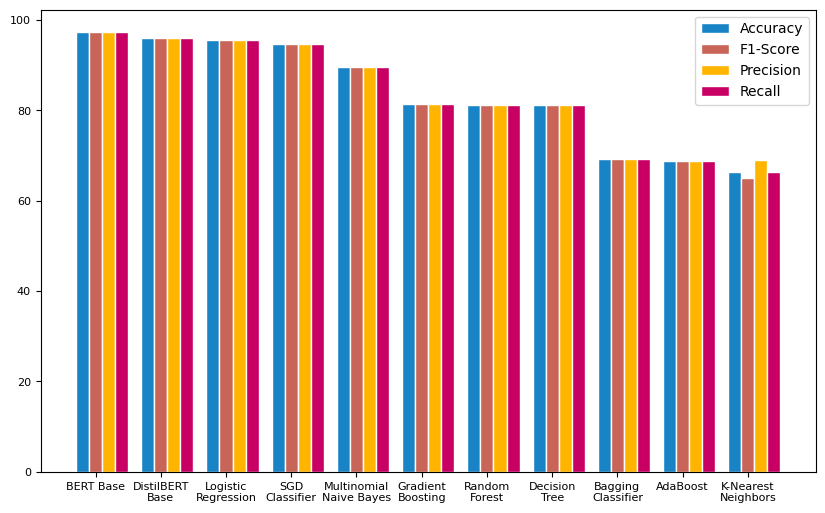

In [19]:
import textwrap

bar_width = 0.2

plt.subplots(figsize=(10,6))

# Set the positions of the bars on the x-axis
r1 = np.arange(len(comp_table.index))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# Create the plot
plt.bar(r1, comp_table['Accuracy'], color='#1984c5', width=bar_width, edgecolor='white', label='Accuracy')
plt.bar(r2, comp_table['F1-Score'], color='#c86558', width=bar_width, edgecolor='white', label='F1-Score')
plt.bar(r3, comp_table['Precision'], color='#ffb400', width=bar_width, edgecolor='white', label='Precision')
plt.bar(r4, comp_table['Recall'], color='#c80064', width=bar_width, edgecolor='white', label='Recall')

# Add x-axis ticks and labels
plt.xticks([r + bar_width for r in range(len(comp_table.index))], [textwrap.fill(label, 11) for label in comp_table.index])

# Add a legend
#plt.legend()
plt.legend()

plt.tick_params(axis='x', labelsize=8, rotation=0)
plt.tick_params(axis='y', labelsize=8)

# Set a gap between each row's bars
plt.subplots_adjust(hspace=2)

# Show the plot
plt.show()


In [ ]:
1-y_test_bert

array([1, 0, 1, ..., 0, 0, 0])

In [21]:
from sklearn.metrics import roc_curve, auc

def draw_roc(model_name,y_test,y_pred):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    fpr_pos, tpr_pos, thresholds_pos = roc_curve(y_test, y_pred)
    auc_pos = auc(fpr_pos, tpr_pos)

    fpr_neg, tpr_neg, thresholds_neg = roc_curve(1 - y_test, 1 - y_pred)
    auc_neg = auc(fpr_neg, tpr_neg)

    plt.plot(fpr_pos, tpr_pos, color='darkorange', lw=2, label='Positive (AUC = %0.2f)' % (auc_pos*100))
    plt.plot(fpr_neg, tpr_neg, color='red', lw=2, label='Negative (AUC = %0.2f)' % (auc_neg*100))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate',fontsize=14)
    plt.ylabel('True Positive Rate',fontsize=14)
    plt.title(model_name,fontsize=20)
    plt.legend(loc="lower right",fontsize=14)
    plt.show()


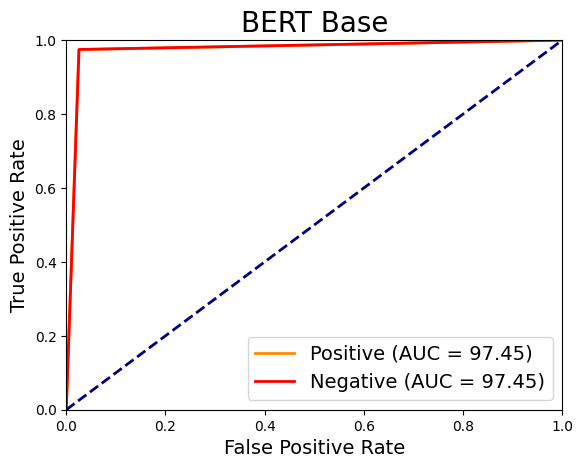

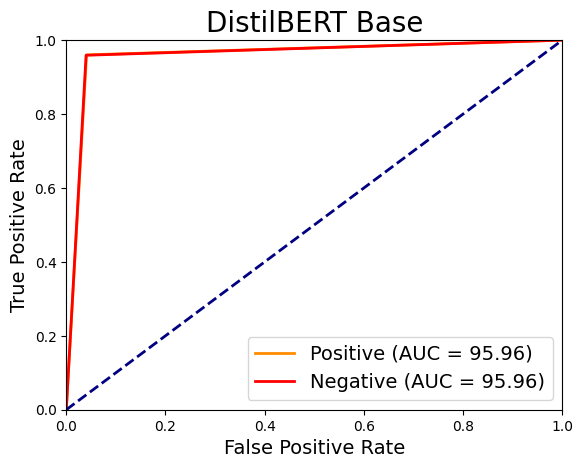

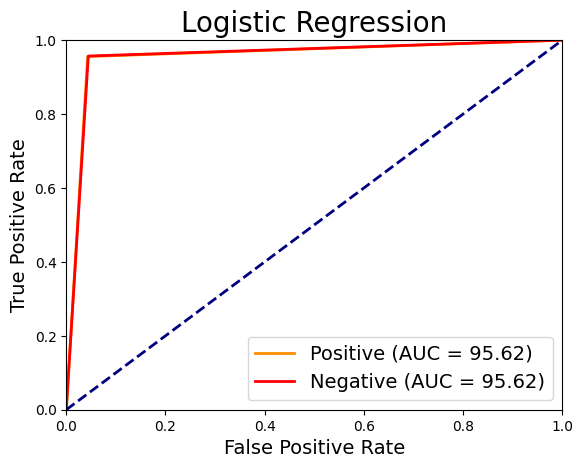

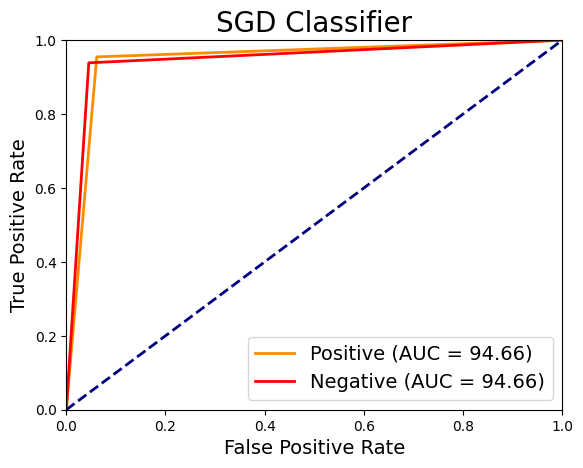

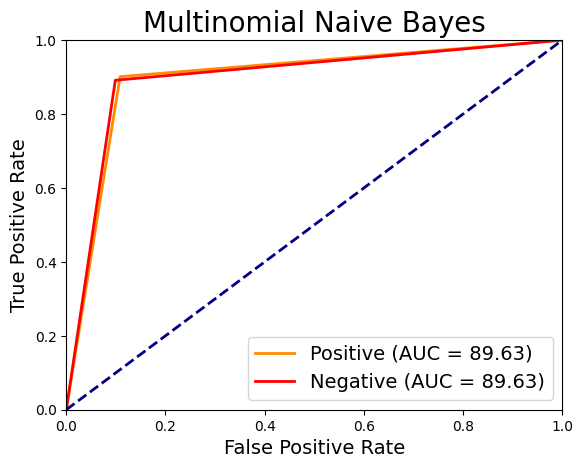

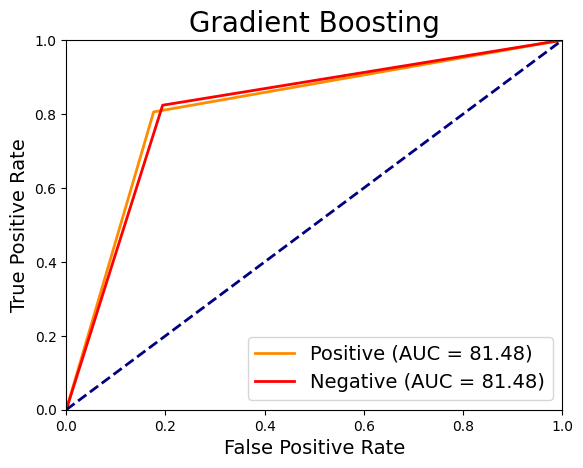

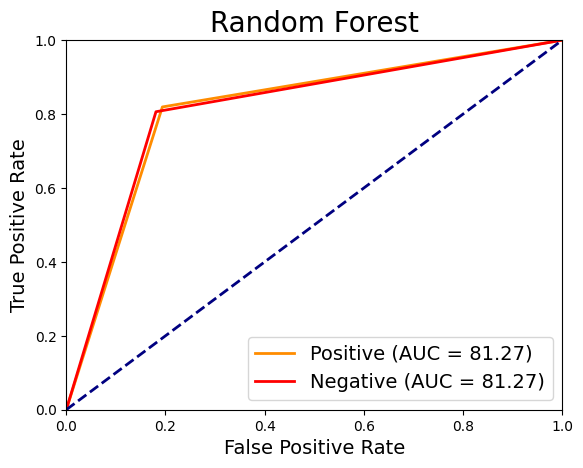

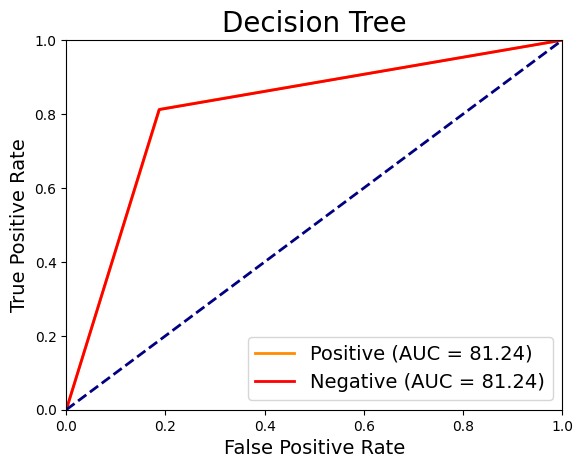

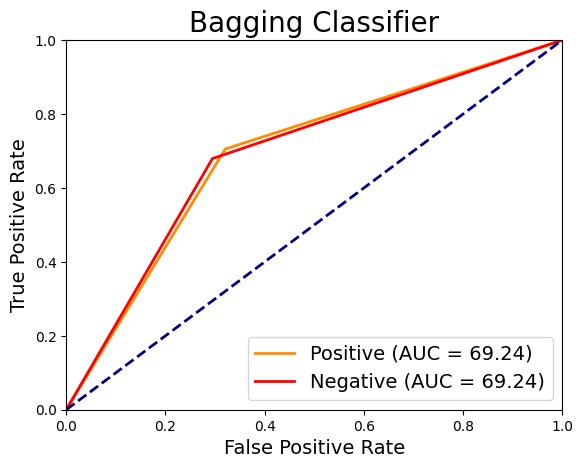

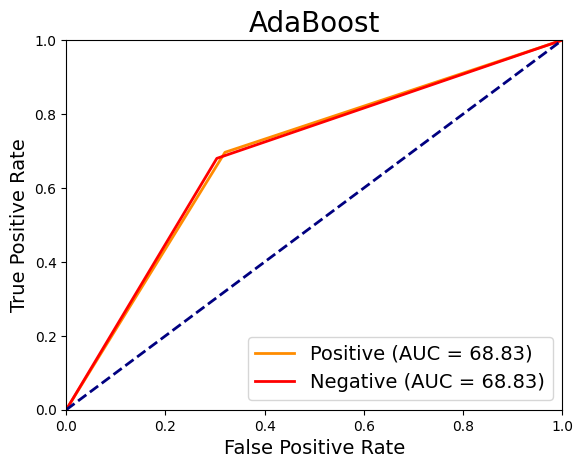

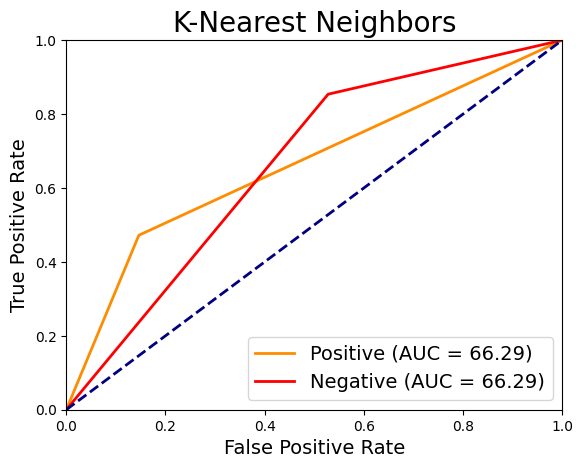

In [22]:
for model_name in models:
    y_pred = globals()[model_name+'_pred']
    if model_name=='DistilBERT':
        draw_roc(MFN[model_name],y_test_DistilBERT,y_pred)
    elif model_name=='BERT':
        draw_roc(MFN[model_name],y_test_bert,y_pred)
    else:
        draw_roc(MFN[model_name],y_test,y_pred)

In [23]:
report = classification_report(y_test_DistilBERT,DistilBERT_pred)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     14666
           1       0.96      0.96      0.96     14472

    accuracy                           0.96     29138
   macro avg       0.96      0.96      0.96     29138
weighted avg       0.96      0.96      0.96     29138



In [24]:
report = classification_report(y_test_bert,BERT_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     29217
           1       0.97      0.97      0.97     29059

    accuracy                           0.97     58276
   macro avg       0.97      0.97      0.97     58276
weighted avg       0.97      0.97      0.97     58276



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)


def print_plt(conf_matrix):
    plt.imshow(conf_matrix, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

thresh = conf_matrix.max() / 2.
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()
